In [1]:
from basic_trainer import get_basic_trainer

c:\Users\quent\anaconda3\envs\capstone_scratch_2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
DATA_PATH = "data/eg"
source_path=f"{DATA_PATH}/train.source"
target_path=f"{DATA_PATH}/train.target"
test_source_path=f"{DATA_PATH}/test.source"
test_target_path=f"{DATA_PATH}/test.target"
model_name = "facebook/bart-base"
output_dir = "KG_finetuned_out2"
max_len = 128
epochs = 6
train_batch_size = 20
num_points = 25_597

In [3]:
trainer = get_basic_trainer(
    source_path=source_path,
    target_path=target_path,
    test_source_path = test_source_path,
    test_target_path = test_target_path,
    model_name=model_name,
    output_dir=output_dir,
    max_len=max_len,
    epochs=epochs,
    train_batch_size=train_batch_size,
    num_points=num_points
)

Map:   0%|          | 0/25596 [00:00<?, ? examples/s]c:\Users\quent\anaconda3\envs\capstone_scratch_2\lib\site-packages\transformers\tokenization_utils_base.py:3970: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
Map: 100%|██████████| 992/992 [00:00<00:00, 3081.95 examples/s]
c:\Users\quent\anaconda3\envs\capstone_scratch_2\lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
c:\Users\quent\OneDrive\Desktop\Code\Efficient-Common-Sense-in-LLMs-via-Knowledge-Graph-Compression\basic_trainer.py:159: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 fo

In [4]:
trainer.train()

Epoch,Training Loss,Validation Loss,Avg Loss Min,Avg Loss Avg
1,2.055400,1.855522,1.209122,1.801700
2,1.780900,1.843152,1.173449,1.787927
3,1.579300,1.841866,1.167069,1.793791
4,1.426300,1.879003,1.182533,1.831075
5,1.270900,1.942277,1.184845,1.888710
6,1.155900,1.994960,1.200106,1.938489
7,1.039000,2.056303,1.235081,1.995838
8,0.939200,2.088155,1.248238,2.031005
9,0.853300,2.161059,1.280830,2.101364
10,0.765400,2.213607,1.301668,2.146136


c:\Users\quent\anaconda3\envs\capstone_scratch_2\lib\site-packages\transformers\modeling_utils.py:2810: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
c:\Users\quent\anaconda3\envs\capstone_scratch_2\lib\site-packages\transformers\tokenization_utils_base.py:3970: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


TrainOutput(global_step=25600, training_loss=0.8959456792473793, metrics={'train_runtime': 4767.6072, 'train_samples_per_second': 107.375, 'train_steps_per_second': 5.37, 'total_flos': 5417558448906240.0, 'train_loss': 0.8959456792473793, 'epoch': 20.0})

# OLD CODE

In [1]:
import torch
from transformers import BartTokenizer, BartForConditionalGeneration
from datasets import Dataset
import bert_score
import os

from basic_trainer import get_basic_trainer
from evaluator import evaluate_model
import networkx as nx
import pickle

c:\Users\quent\anaconda3\envs\capstone_scratch_2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Basic Model
##### No KG

In [2]:
MODEL_NAME_OR_PATH = "facebook/bart-base"

In [3]:
tokenizer_base = BartTokenizer.from_pretrained(MODEL_NAME_OR_PATH)
model_base = BartForConditionalGeneration.from_pretrained(MODEL_NAME_OR_PATH)

In [4]:
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Version: {torch.version.cuda}")

PyTorch Version: 2.5.1+cu124
CUDA Version: 12.4


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print()
model_base.to(device)

Using device: cuda



BartForConditionalGeneration(
  (model): BartModel(
    (shared): BartScaledWordEmbedding(50265, 768, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): BartScaledWordEmbedding(50265, 768, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 768)
      (layers): ModuleList(
        (0-5): 6 x BartEncoderLayer(
          (self_attn): BartSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (final_lay

In [6]:
def generate_explanation(model, tokenizer, sentence: str) -> list:
    # Tokenize the input text
    inputs = tokenizer(sentence, return_tensors="pt").to(device)

    # Generate output using beam search:
    output_ids = model.generate(
        **inputs,
        max_length=60,
        num_beams=3,
        num_return_sequences=3,
        early_stopping=True
    )

    # Decode each of the generated token sequences
    explanations = [
        tokenizer.decode(ids, skip_special_tokens=True)
        for ids in output_ids
    ]
    return explanations

In [7]:
test_sentence = "We use book to know the time."
explanation = generate_explanation(model_base, tokenizer_base, test_sentence)

print("Input Sentence:", test_sentence)
print("Generated Explanation:", explanation)

Input Sentence: We use book to know the time.
Generated Explanation: ['We use book to know the time.', 'We use phone to know the time.', 'We use book to know the time. We use book.']


In [8]:
DATA_PATH = "data/eg"

In [9]:
trainer = get_basic_trainer(
    source_path=DATA_PATH+"/train.source",
    target_path=DATA_PATH+"/train.target",
    model_name="facebook/bart-base", 
    output_dir="basic_finetuned_out",
    max_len=128,
    epochs=1,
    train_batch_size=60
)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]c:\Users\quent\anaconda3\envs\capstone_scratch_2\lib\site-packages\transformers\tokenization_utils_base.py:3961: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
Map: 100%|██████████| 1000/1000 [00:00<00:00, 5838.30 examples/s]
c:\Users\quent\OneDrive\Desktop\Code\Efficient-Common-Sense-in-LLMs-via-Knowledge-Graph-Compression\basic_trainer.py:95: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [10]:
with torch.autograd.profiler.profile(use_cuda=torch.cuda.is_available()) as prof:
    trainer.train()
print(prof.key_averages().table(sort_by="cpu_time_total"))

C:\Users\quent\AppData\Local\Temp\ipykernel_17152\2112205623.py:1: FutureWarning: The attribute `use_cuda` will be deprecated soon, please use ``use_device = 'cuda'`` instead.
  with torch.autograd.profiler.profile(use_cuda=torch.cuda.is_available()) as prof:


Step,Training Loss


c:\Users\quent\anaconda3\envs\capstone_scratch_2\lib\site-packages\transformers\modeling_utils.py:2758: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
    autograd::engine::evaluate_function: AddmmBackward0         4.55%     551.872ms        27.35%        3.315s       2.031ms      48.478ms         0.38%     649.853ms     398.194us          1632  
                                         AddmmBackward0         4.90%     593.916ms        20.03%        2.428s       1.488ms      53.420ms         0.42%     522.277ms     320.023us          1632  
         

In [32]:
output_dir = "basic_finetuned_out"
checkpoints = [name for name in os.listdir(output_dir) if name.startswith("checkpoint")]
print("Available checkpoints:", checkpoints)

Available checkpoints: ['checkpoint-1281']


In [12]:
FINE_TUNED_MODEL_DIR = "basic_finetuned_out/checkpoint-1281"
tokenizer = BartTokenizer.from_pretrained(FINE_TUNED_MODEL_DIR)
model = BartForConditionalGeneration.from_pretrained(FINE_TUNED_MODEL_DIR)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BartForConditionalGeneration(
  (model): BartModel(
    (shared): BartScaledWordEmbedding(50265, 768, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): BartScaledWordEmbedding(50265, 768, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 768)
      (layers): ModuleList(
        (0-5): 6 x BartEncoderLayer(
          (self_attn): BartSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (final_lay

In [13]:
test_sentence = "I  can count  stars."
explanation = generate_explanation(model, tokenizer, test_sentence)

print("Input Sentence:", test_sentence)
print("Generated Explanation:", explanation)

Input Sentence: I  can count  stars.
Generated Explanation: ['Stars are not real.', 'Stars cannot be counted.', 'stars are not real.']


In [14]:
#evaluate_model(model, tokenizer, "data\eg")

In [15]:
#evaluate on the base model for refernce
#evaluate_model(model_base, tokenizer_base, "data\eg")

# KG 1-hop Model

In [34]:
import json
import pickle
import networkx as nx

# ----------------------------------------------------------------------
# 1) Define your file paths
#    Update these to point to your actual data files.
# ----------------------------------------------------------------------
concept_vocab_path = "data/concept.txt"
relation_vocab_path = "data/relation.txt"
cpnet_path         = "data/cpnet.graph"

# If your data folder has: train.concepts_nv.json and val.concepts_nv.json
# for loading the "allowed" concepts:
data_path = "data/eg"

# ----------------------------------------------------------------------
# 2) Global dictionaries and graphs
# ----------------------------------------------------------------------
concept2id = {}
id2concept = {}
relation2id = {}
id2relation = {}

cpnet = None
cpnet_simple = None

# This will store the "allowed" concept IDs used for BFS filtering
allowed_nodes = set()

# ----------------------------------------------------------------------
# 3) Load vocabularies
# ----------------------------------------------------------------------
def load_resources():
    global concept2id, id2concept, relation2id, id2relation

    # Load concept vocabulary
    with open(concept_vocab_path, "r", encoding="utf8") as f:
        for line in f:
            concept = line.strip()
            cid = len(concept2id)
            concept2id[concept] = cid
            id2concept[cid] = concept

    # Load relation vocabulary
    with open(relation_vocab_path, "r", encoding="utf8") as f:
        for line in f:
            rel = line.strip()
            rid = len(relation2id)
            relation2id[rel] = rid
            id2relation[rid] = rel

# ----------------------------------------------------------------------
# 4) Load the ConceptNet graph
# ----------------------------------------------------------------------
def load_cpnet():
    global cpnet, cpnet_simple
    print("Loading cpnet...")
    with open(cpnet_path, "rb") as f:
        cpnet = pickle.load(f)
    print("Done")

    # Build an undirected version
    cpnet_simple = nx.Graph()
    for u, v, data in cpnet.edges(data=True):
        w = data["weight"] if "weight" in data else 1.0
        if cpnet_simple.has_edge(u, v):
            cpnet_simple[u][v]["weight"] += w
        else:
            cpnet_simple.add_edge(u, v, weight=w)

# ----------------------------------------------------------------------
# 5) Load "allowed" concepts from data
#    This replicates the original approach that collects 
#    all concepts from train/val files, then filters them to those in concept2id.
# ----------------------------------------------------------------------
def load_total_concepts(data_path):
    global allowed_nodes  # we'll store them in this set
    total_concepts = []

    # We replicate the original idea of reading "train.concepts_nv.json" and "val.concepts_nv.json"
    # Adjust the filenames if yours differ
    for fname in ["train.concepts_nv.json", "val.concepts_nv.json"]:
        full_path = f"{data_path}/{fname}"
        try:
            with open(full_path, "r", encoding="utf8") as f:
                for line in f.readlines():
                    item = json.loads(line)
                    # 'qc' => question concepts, 'ac' => answer concepts
                    # The original code extends them together
                    total_concepts.extend(item['qc'] + item['ac'])
        except FileNotFoundError:
            print(f"Warning: file not found -> {full_path}")

    # Unique
    total_concepts = list(set(total_concepts))

    # Convert them to IDs, filter out unknowns
    valid_ids = []
    for cpt in total_concepts:
        if cpt in concept2id:
            valid_ids.append(concept2id[cpt])

    allowed_nodes = set(valid_ids)
    print(f"Loaded {len(allowed_nodes)} allowed concept IDs from train/val data.")

# ----------------------------------------------------------------------
# 6) BFS-based triple extraction with filtering
#    This matches the original code's "find_neighbours_frequency" approach:
#    - BFS up to T hops
#    - At each hop, keep top max_B neighbors by frequency
#    - Filter expansions to "allowed_nodes"
# ----------------------------------------------------------------------
def get_triples_for_token_bfs(input_token, T=2, max_B=100):
    """
    Perform BFS from `input_token` (string) in the UNDIRECTED `cpnet_simple`.
    Restrict expansions to `allowed_nodes`.
    Return a list of (src_str, [rel_ids], tgt_str) edges.
    """

    if input_token not in concept2id:
        return []

    start_id = concept2id[input_token]
    if start_id not in cpnet_simple:
        return []

    # We'll track how many hops from the starting token
    visited = {start_id: 0}
    frontier = [start_id]

    # Ets: a place to store discovered edges
    # Ets[tgt_node] = {src_node: [rel_ids], ...}
    Ets = {}

    for hop_num in range(T):
        neighbor_freq = {}  # track frequency of each neighbor in this hop

        for src_node in frontier:
            # If src_node not in cpnet_simple adjacency, skip
            if src_node not in cpnet_simple:
                continue

            # Expand neighbors
            for nbr in cpnet_simple[src_node]:
                # Must not be visited; must be in allowed nodes
                if nbr not in visited and nbr in allowed_nodes:
                    # Count how many times we see 'nbr'
                    neighbor_freq[nbr] = neighbor_freq.get(nbr, 0) + 1

                    # Retrieve relations from the directed graph `cpnet`
                    if cpnet.has_edge(src_node, nbr):
                        rel_ids = []
                        for key, edge_data in cpnet[src_node][nbr].items():
                            if "rel" in edge_data:
                                rel_ids.append(edge_data["rel"])

                        # Store them
                        if nbr not in Ets:
                            Ets[nbr] = {src_node: rel_ids}
                        else:
                            Ets[nbr][src_node] = rel_ids

        # Sort neighbors by frequency, keep top `max_B`
        sorted_nbrs = sorted(neighbor_freq.items(), key=lambda x: x[1], reverse=True)
        sorted_nbrs = sorted_nbrs[:max_B]

        # Mark them visited, set BFS frontier for the next hop
        new_frontier = []
        for nid, _freq in sorted_nbrs:
            visited[nid] = hop_num + 1
            new_frontier.append(nid)

        frontier = new_frontier

    # ---------------------------------------------
    # Collect final edges from Ets
    # Only keep edges if both ends are visited
    # ---------------------------------------------
    final_triples = []
    for tgt_node, src_map in Ets.items():
        if tgt_node in visited:
            for src_node, rel_ids in src_map.items():
                if src_node in visited:
                    src_str = id2concept[src_node].replace("_", " ")
                    tgt_str = id2concept[tgt_node].replace("_", " ")
                    final_triples.append((src_str, rel_ids, tgt_str))

    return final_triples

# ----------------------------------------------------------------------
# 7) Putting It All Together in a Jupyter Notebook
# ----------------------------------------------------------------------
# You can run these functions in separate cells or in a single cell.

# Load resources
load_resources()
load_cpnet()

# Load the "allowed" nodes from your train/val data
load_total_concepts(data_path)  # e.g., "data" folder with train.concepts_nv.json, val.concepts_nv.json

# Let's test with "mosquito"
test_token = "mosquito"

# 7) Show BFS-limited edges
bfs_filtered = get_triples_for_token_bfs(test_token, T=2, max_B=100)
print(f"\nBFS-limited edges for '{test_token}' -> {len(bfs_filtered)}")
for t in bfs_filtered[:5]:
    print("  ", t)
print("...")


Loading cpnet...
Done
Loaded 3947 allowed concept IDs from train/val data.

BFS-limited edges for 'mosquito' -> 258
   ('mosquito', [1, 15], 'water')
   ('mosquito', [32], 'bit')
   ('mosquito', [32], 'bite')
   ('mosquito', [15], 'sucking')
   ('mosquito', [15], 'bump')
...


In [35]:
allowed_nodes

{196608,
 16385,
 4,
 5,
 16391,
 8,
 9,
 10,
 11,
 12,
 16397,
 401416,
 65553,
 40981,
 352281,
 16416,
 213032,
 147497,
 24618,
 16427,
 16429,
 50,
 51,
 172084,
 8246,
 8248,
 131129,
 13037,
 60,
 62,
 393280,
 49218,
 75,
 16460,
 196685,
 57426,
 8275,
 73812,
 16468,
 8278,
 24663,
 196695,
 8279,
 65626,
 16475,
 49238,
 24669,
 213085,
 73817,
 41056,
 204897,
 98,
 109,
 110,
 111,
 41072,
 16498,
 73842,
 115,
 24693,
 118,
 16501,
 82046,
 335999,
 73856,
 73857,
 73858,
 24707,
 196737,
 344197,
 360584,
 136,
 137,
 82059,
 140,
 73870,
 16528,
 196753,
 73872,
 24722,
 8341,
 16536,
 49304,
 8347,
 8351,
 8352,
 24739,
 8356,
 8355,
 82086,
 16550,
 172,
 175,
 177,
 178,
 179,
 180,
 181,
 16566,
 16564,
 16568,
 8376,
 114876,
 16572,
 82112,
 8384,
 194,
 197,
 204,
 8401,
 8402,
 24785,
 213,
 214,
 106710,
 73949,
 73952,
 16609,
 24801,
 8419,
 8420,
 8421,
 8422,
 41190,
 82149,
 41194,
 73962,
 16620,
 16621,
 237,
 239,
 57585,
 123121,
 123122,
 57588,
 4120

In [36]:
def get_triples_for_message(message, T=2, max_B=100):
    """
    For each token in the input message that exists in the concept vocabulary,
    perform a BFS-based connection search in the ConceptNet graph and return the results.
    
    Parameters:
        message (str): The input message (e.g., sentence or paragraph).
        T (int): Number of BFS hops (default 2).
        max_B (int): Maximum number of neighbors per hop (default 100).
    
    Returns:
        dict: A dictionary mapping each token (that exists in concept2id) to its list of triples.
              Each triple is of the form (src_str, [rel_ids], tgt_str).
    """
    # Tokenize the message. Here, we simply split on whitespace and lower the case.
    # You can replace this with a more advanced tokenizer if needed.
    tokens = message.lower().split()
    
    message_triples = {}
    
    for token in tokens:
        if token in concept2id:
            # Use your existing function to get BFS triples for this token.
            triples = get_triples_for_token_bfs(token, T=T, max_B=max_B)
            if triples:
                message_triples[token] = triples
        else:
            print(f"Warning: Token '{token}' not found in the concept vocabulary. Skipping.")
    
    return message_triples

In [37]:
get_triples_for_message("She parachuted into the grocery store from a plane.", T=2, max_B=100)

{'parachuted': [('parachuted', [15], 'parachute'),
  ('parachute', [7, 15], 'descend'),
  ('parachute', [15], 'fall'),
  ('parachute', [32], 'sky'),
  ('parachute', [15], 'skin'),
  ('parachute', [32], 'drop'),
  ('parachute', [15], 'collar'),
  ('parachute', [7], 'dive'),
  ('parachute', [32, 15, 32], 'jump'),
  ('parachute', [15], 'mammal'),
  ('parachute', [15], 'fold'),
  ('parachute', [32], 'backpack'),
  ('parachute', [15], 'weight'),
  ('parachute', [32], 'cord'),
  ('parachute', [15], 'fabric'),
  ('parachute', [15], 'web'),
  ('parachute', [15], 'device'),
  ('parachute', [7, 15], 'glide'),
  ('parachute', [15], 'authority')],
 'grocery': [('grocery', [22], 'vegetable'),
  ('grocery', [32], 'egg'),
  ('grocery', [22], 'food'),
  ('grocery', [22], 'butter'),
  ('grocery', [15], 'sell'),
  ('grocery', [32, 32], 'sack'),
  ('grocery', [18], 'potato'),
  ('grocery', [32], 'express'),
  ('grocery', [15], 'store'),
  ('grocery', [32], 'produce'),
  ('grocery', [32], 'product'),
  ('

In [20]:
def get_subgraph_for_message(message, T=2, max_B=100):
    """
    For an input message, perform BFS-based extraction for each token and build a subgraph.
    
    The subgraph is a NetworkX undirected graph containing all nodes and edges 
    (with relation information) that were extracted for the message.
    
    Parameters:
        message (str): The input message.
        T (int): Number of BFS hops.
        max_B (int): Maximum number of neighbors per hop.
    
    Returns:
        networkx.Graph: A subgraph containing the extracted nodes and edges.
                        Each edge has an attribute 'rel_ids' (a list of relation IDs).
    """
    message_triples = get_triples_for_message(message, T, max_B)
    
    # Create an empty undirected graph for the subgraph
    subgraph = nx.Graph()
    
    # Iterate over all tokens and their associated triples, adding nodes and edges.
    for token, triples in message_triples.items():
        for src, rel_ids, tgt in triples:
            # Add the nodes (this is idempotent if they already exist)
            subgraph.add_node(src)
            subgraph.add_node(tgt)
            
            # If the edge already exists, merge the relation information.
            if subgraph.has_edge(src, tgt):
                existing_rel_ids = subgraph[src][tgt].get("rel_ids", [])
                # Merge without duplicates
                merged = list(set(existing_rel_ids + rel_ids))
                subgraph[src][tgt]["rel_ids"] = merged
            else:
                subgraph.add_edge(src, tgt, rel_ids=rel_ids)
    
    return subgraph

In [21]:
message = "She parachuted into the grocery store from a plane."

In [22]:
subgraph = get_subgraph_for_message(message, T=2, max_B=100)

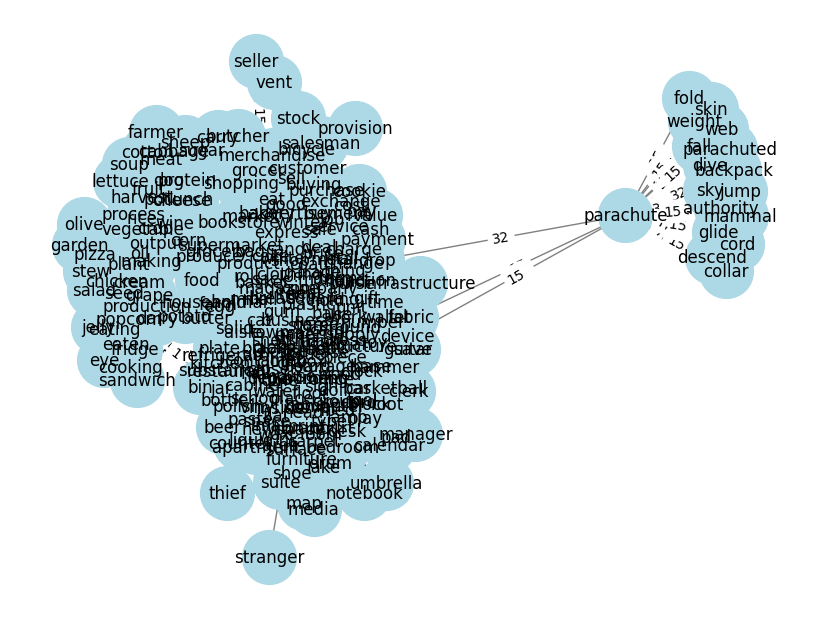

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
pos = nx.spring_layout(subgraph)
nx.draw(subgraph, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=1500)
edge_labels = { (u,v): ",".join(map(str, data["rel_ids"])) for u, v, data in subgraph.edges(data=True) }
nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels)
plt.show()

In [24]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Tue_May__3_19:00:59_Pacific_Daylight_Time_2022
Cuda compilation tools, release 11.7, V11.7.64
Build cuda_11.7.r11.7/compiler.31294372_0


In [25]:
degree_dict = dict(subgraph.degree())

# Count nodes with more than one connection
nodes_more_than_one = [node for node, degree in degree_dict.items() if degree > 1]
num_nodes_more_than_one = len(nodes_more_than_one)

print(f"Number of nodes with more than one connection: {num_nodes_more_than_one}")
print("Nodes with more than one connection:", nodes_more_than_one)

Number of nodes with more than one connection: 254
Nodes with more than one connection: ['parachute', 'drop', 'fabric', 'device', 'grocery', 'vegetable', 'egg', 'food', 'butter', 'sell', 'sack', 'potato', 'express', 'store', 'produce', 'product', 'supermarket', 'aisle', 'market', 'shop', 'bag', 'household', 'grape', 'popcorn', 'grocer', 'animal', 'plant', 'corn', 'fruit', 'meat', 'chicken', 'cabbage', 'lettuce', 'cotton', 'crop', 'farm', 'farmer', 'garden', 'milk', 'oil', 'olive', 'pizza', 'rice', 'salad', 'soup', 'stew', 'house', 'good', 'fridge', 'plate', 'magazine', 'cake', 'container', 'cooking', 'dairy', 'eat', 'eaten', 'eating', 'item', 'making', 'output', 'production', 'protein', 'refrigerator', 'sandwich', 'seed', 'eye', 'roll', 'lunch', 'bar', 'jar', 'kitchen', 'mall', 'shelf', 'cat', 'dog', 'bread', 'candy', 'cheese', 'substance', 'wine', 'basket', 'bin', 'board', 'butcher', 'carry', 'closet', 'cream', 'harvest', 'jelly', 'pot', 'process', 'restaurant', 'sheep', 'sugar', 'gam

In [26]:
degree_dict

{'parachuted': 1,
 'parachute': 19,
 'descend': 1,
 'fall': 1,
 'sky': 1,
 'skin': 1,
 'drop': 10,
 'collar': 1,
 'dive': 1,
 'jump': 1,
 'mammal': 1,
 'fold': 1,
 'backpack': 1,
 'weight': 1,
 'cord': 1,
 'fabric': 10,
 'web': 1,
 'device': 14,
 'glide': 1,
 'authority': 1,
 'grocery': 20,
 'vegetable': 22,
 'egg': 36,
 'food': 80,
 'butter': 26,
 'sell': 20,
 'sack': 13,
 'potato': 22,
 'express': 19,
 'store': 118,
 'produce': 29,
 'product': 56,
 'supermarket': 22,
 'aisle': 10,
 'market': 33,
 'shop': 37,
 'bag': 25,
 'household': 7,
 'grape': 15,
 'popcorn': 5,
 'grocer': 8,
 'animal': 11,
 'plant': 5,
 'corn': 9,
 'fruit': 5,
 'meat': 4,
 'chicken': 4,
 'cabbage': 4,
 'lettuce': 3,
 'cotton': 3,
 'crop': 5,
 'farm': 12,
 'farmer': 3,
 'garden': 3,
 'milk': 24,
 'oil': 4,
 'olive': 3,
 'pizza': 3,
 'rice': 4,
 'salad': 4,
 'soup': 3,
 'stew': 3,
 'house': 46,
 'good': 13,
 'fridge': 4,
 'plate': 10,
 'magazine': 10,
 'cake': 12,
 'container': 21,
 'cooking': 3,
 'dairy': 4,
 'eat